<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230610_finetuning_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segment_anything segment_geospatial opencv-python pycocotools matplotlib onnxruntime onnx torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 1: Data Preparation

### Load Sample Training data from Disk

### Format data using SAM preprocess functions
* use utils.transform.ResizeLongestSide to resize the image
* convert the image to a pytorch tensor
* use SAM preprocess functions

## Step 2: Getting SAM module instance and prepare it for **finetuning**

## Step 3: Starting Finetuning using torch or lightning



## Step 4: Evaluation


Most of the following code is from encord.com:

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from samgeo import download_checkpoint
from segment_anything import sam_model_registry, SamPredictor


#model_type = 'vit_h'
#checkpoint = 'sam_vit_h_4b8939.pth'
#checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
device = 'cuda:0'
#device = 'cpu:0'

# Download the checkpoint if it does not exist
CACHE_PATH = os.environ.get(
    "TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints")
)

basename = os.path.basename(checkpoint)
checkpoint = os.path.join(CACHE_PATH, basename)
download_checkpoint(url=checkpoint_url, output=checkpoint)

# Load up the model with default weights
sam_model_original = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_original.to(device)

/root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth already exists. Skip downloading. Set overwrite=True to overwrite.


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


We convert the input images into a format SAM's internal functions expect.

In [3]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide
import cv2
import random
from typing import List, Dict
import numpy as np

transform = ResizeLongestSide(sam_model_original.image_encoder.img_size)

def preprocess_input_image(image_rgb):
  input_image = transform.apply_image(image_rgb)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model_original.preprocess(transformed_image)
  original_image_size = image_rgb.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  return input_image, input_size, original_image_size

In [13]:
from pathlib import Path
import numpy as np
from typing import List, Dict
from tqdm import tqdm
from skimage.io import imread

def box_xywh2xyxy(box: np.ndarray) -> np.ndarray:
  """Expects a numpy array shape Bx4"""

  if len(box)==0:
    return box

  box = box.copy()
  box[..., 2] += box[..., 0]  # Width to x2
  box[..., 3] += box[..., 1]  # Height to y2
  return box

def load_dataset(dataset_path: Path) -> List[Dict] :
  dataset = []
  for datapoint_pth in tqdm(dataset_path.glob('*')):
    sat = imread(datapoint_pth / 'sat.png')

    # Some of the tiles are cut off and we don't get a full tile
    if sat.shape[0]!=sat.shape[1]:
      logger.warn(f"Skipping tile with dims {sat.shape}")
      continue
    box_xywh = np.load(datapoint_pth / 'bboxes.npy')  # loaded in xywh format
    box_xyxy = box_xywh2xyxy(box_xywh)
    dataset.append({
        'tile_id': datapoint_pth.name,
        'bboxes': box_xyxy,
        'points': np.load(datapoint_pth / 'points.npy'),
        'contours': np.load(datapoint_pth / 'contours.npy', allow_pickle=True),
        'mask': imread(datapoint_pth / 'mask.png')//255,
        'sat': sat,
    })
  return dataset

In [5]:
# from segment_anything.utils.amg import box_xyxy_to_xywh

import logging

logger = logging.getLogger()

dataset_folder = Path('drive/MyDrive/sam-bridges/datasets/munich_z16_v3')



train_dataset = load_dataset(dataset_folder / "train")
test_dataset = load_dataset(dataset_folder / "test")

166it [00:02, 61.61it/s]<ipython-input-5-afc6e7ffb660>:31: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f"Skipping tile with dims {sat.shape}")
308it [02:26,  1.04s/it]WARNING:root:Skipping tile with dims (256, 43, 3)
325it [02:44,  1.98it/s]
42it [00:45,  1.01s/it]WARNING:root:Skipping tile with dims (13, 256, 3)
43it [00:45,  1.29it/s]WARNING:root:Skipping tile with dims (13, 256, 3)
44it [00:45,  1.04s/it]


## Run fine tuning

This is the main training loop.

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


In [4]:
import pickle

# Preprocess image embeddings

def preprocess_image_embeddings(dataset):
  for datapoint in tqdm(dataset):
    input_image, input_size, original_image_size = preprocess_input_image(datapoint['sat'])
    datapoint['input_size'] = input_size
    datapoint['original_image_size'] = original_image_size

    input_image = input_image.to(device)
    with torch.no_grad():
      datapoint['image_embedding'] = sam_model_original.image_encoder(input_image)


if os.path.exists('drive/MyDrive/sam-bridges/train_dataset.pckl'):
  with open('drive/MyDrive/sam-bridges/train_dataset.pckl', 'rb') as fp:
      train_dataset = pickle.load(fp)

  with open('drive/MyDrive/sam-bridges/test_dataset.pckl', 'rb') as fp:
      test_dataset = pickle.load(fp)

else:
  preprocess_image_embeddings(train_dataset)
  preprocess_image_embeddings(test_dataset)

  with open('drive/MyDrive/sam-bridges/train_dataset.pckl', 'wb') as fp:
      pickle.dump(train_dataset, fp)

  with open('drive/MyDrive/sam-bridges/test_dataset.pckl', 'wb') as fp:
      pickle.dump(test_dataset, fp)

In [85]:
from statistics import mean

from tqdm import tqdm, trange
from torch.nn.functional import threshold, normalize
import random
from torchmetrics import JaccardIndex

random.seed(57)


def contour_to_mask(contour, shape):
  mask = np.zeros(shape, np.uint8)
  cv2.drawContours(mask, [contour], -1, 255,-1)
  return mask

def validation(sam_model, test_dataset, loss_fn, skip_empty=False, mode='boxes'):
  predictor = SamPredictor(sam_model)
  losses = []
  for test_dp in test_dataset:
    predictor.original_size = test_dp['original_image_size']
    predictor.input_size = test_dp['input_size']
    predictor.features = test_dp['image_embedding']
    predictor.is_image_set = True

    if skip_empty and len(test_dp['contours']==0):
      continue

    object_id = 0  # only first object
    gt_mask = contour_to_mask(test_dp['contours'][object_id], test_dp['original_image_size'])
    box = test_dp['bboxes'][0] if mode=='boxes' else None

    # Only taking single foreground point

    points = [p for p in test_dp['points'][object_id] if p[2]==1]
    if len(points)>0:
      points = [points[0]]
      point_coords = np.array([p[:2] for p in points]) if mode=='points' else None
      point_labels = np.array([p[2] for p in points]) if mode=='points' else None
    else:
      point_coords, point_labels = None, None
      continue

    mask_pred, _, _ = predictor.predict(
      point_coords=point_coords,
      point_labels=point_labels,
      box=box,
      multimask_output=False,
      return_logits=True
    )


    mask_pred_tensor = torch.as_tensor(mask_pred[0, :,:], dtype=torch.float32)
    gt_mask_tensor = torch.as_tensor(gt_mask > 0, dtype=torch.float32)
    loss = loss_fn(torch.stack([1-upscaled_masks, upscaled_masks], axis=1), gt_binary_mask)

    losses.append(loss.item())
    #np.save('mask_pred.npy', mask_pred_tensor.detach().numpy())
    #np.save('mask_gt.npy', gt_mask_tensor.numpy())
    #print('LOSS:', losses[-1])
    #import pdb; pdb.set_trace()

  return losses


# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5
wd = 0
SKIP_EMPTY_TILES = False
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()

#jaccard = JaccardIndex(task='binary', num_classes=2).to(device)
#loss_fn = lambda x,y: 1-jaccard(x,y)
# loss_fn = jaccard_loss
# loss_fn = torch.nn.NLLLoss()
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 10
losses = []
val_losses = []
print("Val before training:", mean(validation(sam_model, test_dataset, loss_fn, SKIP_EMPTY_TILES, mode='points')))

for epoch in trange(num_epochs):
  random.shuffle(train_dataset)
  epoch_losses = []
  for train_dp in train_dataset:
    input_size = train_dp['input_size']
    original_image_size = train_dp['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      if "image_embedding" not in train_dp:
        input_image = train_dp['input_image'].to(device)
        image_embedding = sam_model.image_encoder(input_image)
        train_dp['image_embedding'] = image_embedding

      # selected_box, gt_mask = select_single_box(train_dp['bboxes'], train_dp['mask'])
      mode = random.choice(['points', 'boxes'])
      object_id = random.randint(0, len(train_dp['bboxes'])-1)
      gt_mask = contour_to_mask(train_dp['contours'][object_id], train_dp['original_image_size'])
      box = train_dp['bboxes'][object_id] if mode=='boxes' else None
      point_coords = [p[:2] for p in train_dp['points'][object_id]] if mode=='points' else None
      point_labels = [p[2] for p in train_dp['points'][object_id]] if mode=='points' else None

      if box is not None:
        box = transform.apply_boxes(box, original_image_size)
        boxes_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        boxes_torch = boxes_torch[None, :]
      else:
        boxes_torch = None

      if point_coords is not None:
        point_coords = transform.apply_coords(np.array(point_coords), original_image_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device)
        labels_torch = torch.as_tensor(np.array(point_labels), dtype=torch.int, device=device)
        coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        points = (coords_torch, labels_torch)
      else:
          points = None

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=points,
          boxes=boxes_torch,
          masks=None,
      )

    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=train_dp['image_embedding'],
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    #binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(gt_mask, (1, 1, gt_mask.shape[0], gt_mask.shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.long)
    loss = loss_fn(torch.stack([1-upscaled_masks, upscaled_masks], axis=1), gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)

  # Commented for debug
  epoch_val_losses = validation(sam_model, test_dataset, loss_fn, SKIP_EMPTY_TILES, mode='points')
  val_losses.append(epoch_val_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')
  print(f'Val loss: {mean(epoch_val_losses)}')


Val before training: 0.004556063562631607


 10%|█         | 1/10 [00:09<01:25,  9.44s/it]

EPOCH: 0
Mean loss: 0.018039335176671622
Val loss: 0.009836104698479176


 20%|██        | 2/10 [00:16<01:05,  8.21s/it]

EPOCH: 1
Mean loss: 0.011773756264702449
Val loss: 0.0034870095551013947


 30%|███       | 3/10 [00:25<00:58,  8.29s/it]

EPOCH: 2
Mean loss: 0.009303416295549054
Val loss: 0.0022073769941926003


 40%|████      | 4/10 [00:32<00:46,  7.76s/it]

EPOCH: 3
Mean loss: 0.008037555999563713
Val loss: 0.00480210455134511


 50%|█████     | 5/10 [00:40<00:40,  8.01s/it]

EPOCH: 4
Mean loss: 0.008402408007271054
Val loss: 0.0018999128369614482


 60%|██████    | 6/10 [00:47<00:30,  7.64s/it]

EPOCH: 5
Mean loss: 0.006871858326566475
Val loss: 0.00158592383377254


 70%|███████   | 7/10 [00:55<00:23,  7.87s/it]

EPOCH: 6
Mean loss: 0.006762392759458637
Val loss: 0.003894897410646081


 80%|████████  | 8/10 [01:02<00:15,  7.54s/it]

EPOCH: 7
Mean loss: 0.0061354146090940925
Val loss: 0.0013479951303452253


 90%|█████████ | 9/10 [01:11<00:07,  7.93s/it]

EPOCH: 8
Mean loss: 0.00673669732760367
Val loss: 0.005758742336183786


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]

EPOCH: 9
Mean loss: 0.00592253682612306
Val loss: 0.0009736592182889581


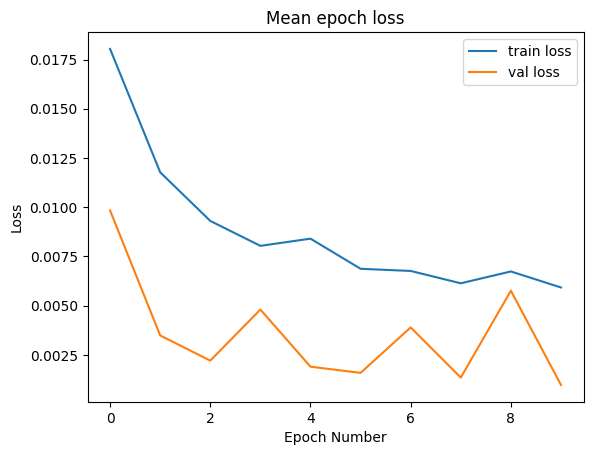

In [86]:
mean_losses = [mean(x) for x in losses]
mean_losses
mean_val_losses = [mean(x) for x in val_losses]

plt.plot(list(range(len(mean_losses))), mean_losses, label='train loss')
plt.plot(list(range(len(mean_losses))), mean_val_losses, label='val loss')
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()

plt.show()

## We can compare our tuned model to the original model

In [91]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [92]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [93]:
#tile_id = 206
#test_datapoint = [d for d in test_dataset if d['tile_id']=="206"][0]


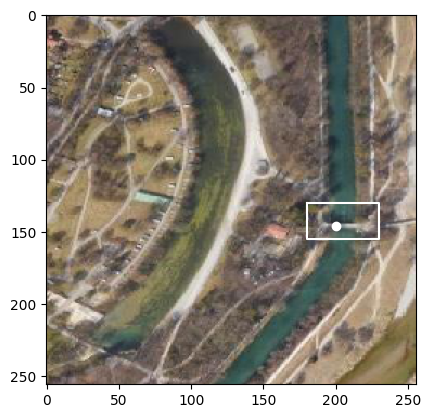

In [94]:

test_datapoint = test_dataset[1]
predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])

debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 180, 130, 50, 25
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 200, 146
plt.plot(point_x, point_y, color='white', marker = 'o')

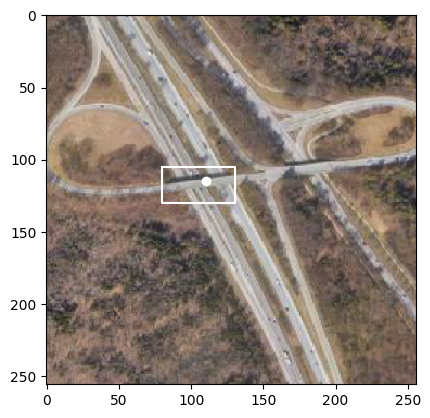

In [137]:
test_datapoint = test_dataset[13]
predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])

debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 80, 105, 50, 25
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 110, 115
plt.plot(point_x, point_y, color='white', marker = 'o')

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

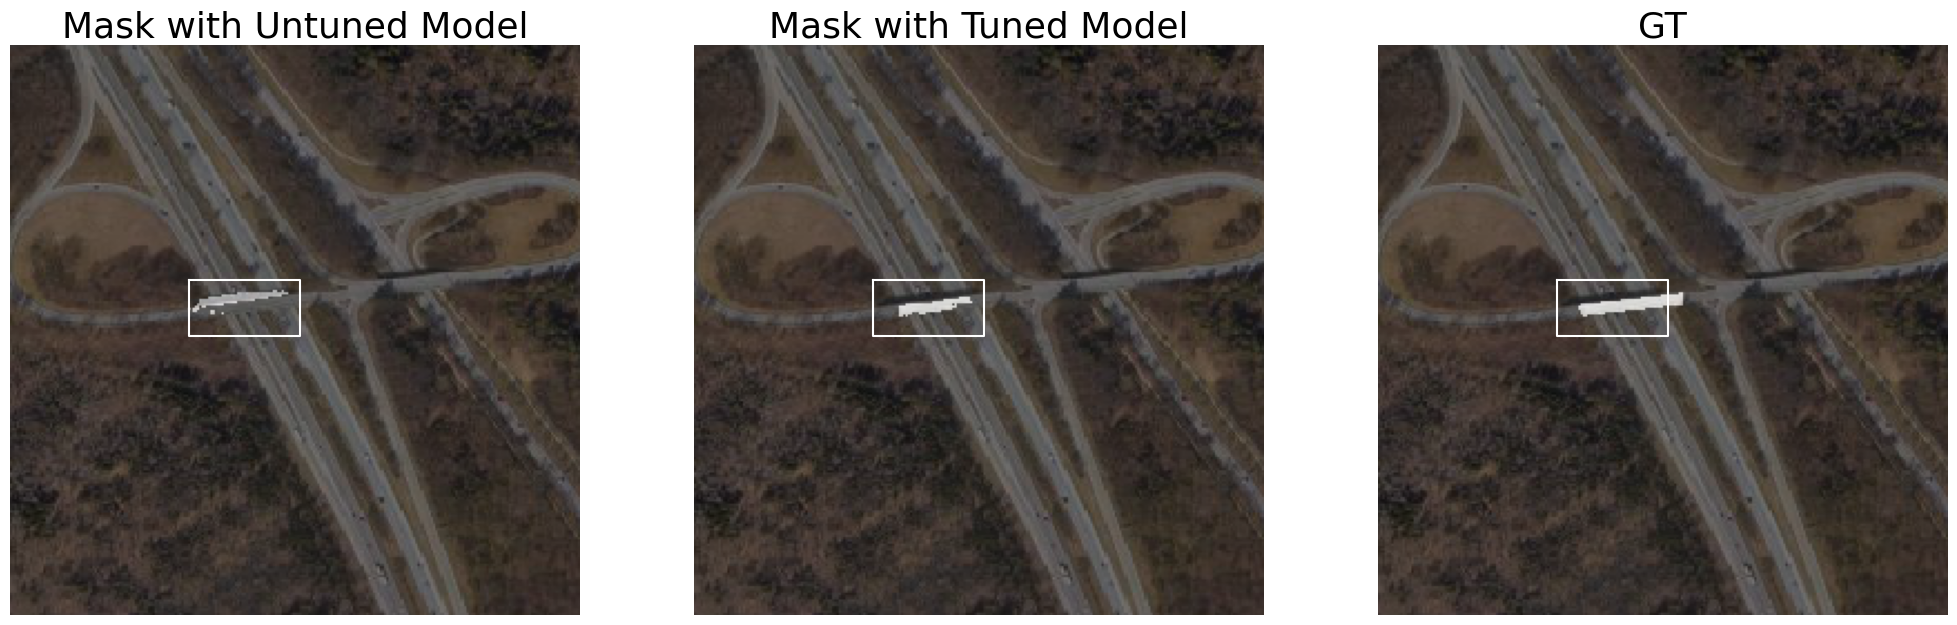

In [138]:
input_bbox = np.array(input_bbox)

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)
masks_tuned = masks_tuned > 0.5
masks_orig = masks_orig > 0.5


%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))

axs[0].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[0].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[0].set_title('Mask with Untuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[1].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[1].set_title('Mask with Tuned Model', fontsize=26)
axs[1].axis('off')


axs[2].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[test_datapoint['mask']*255], axis=-1)).astype(int))
axs[2].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[2].set_title('GT', fontsize=26)
axs[2].axis('off')

plt.show()

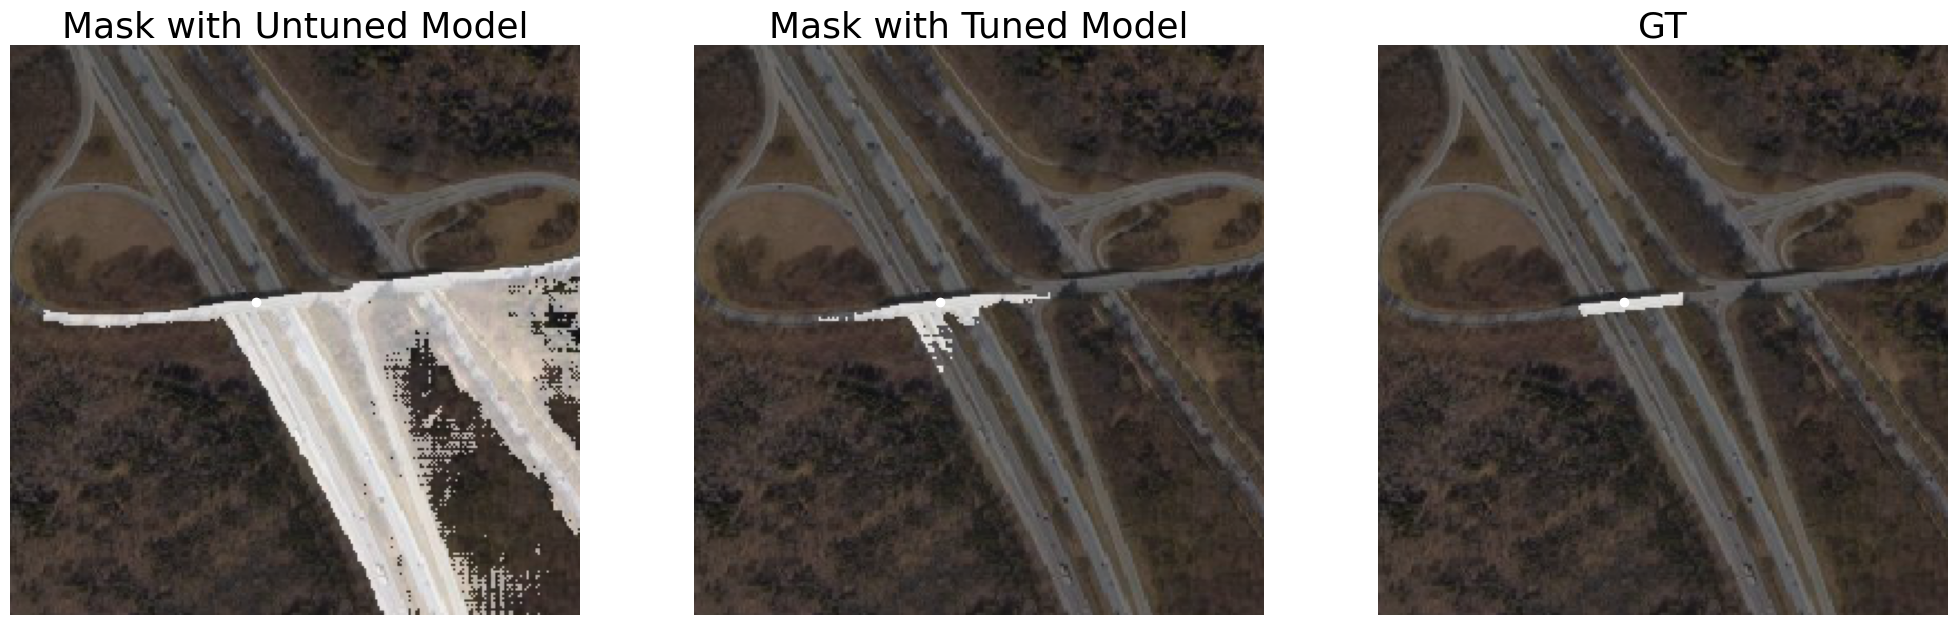

In [139]:
input_points = np.array([[point_x, point_y]])
point_labels = np.array([1])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
    return_logits=True
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
    return_logits=True
)

masks_tuned = masks_tuned > 0.5
masks_orig = masks_orig > 0.5

%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))

axs[0].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[0].plot(point_x, point_y, color='white', marker = 'o')
axs[0].set_title('Mask with Untuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[1].plot(point_x, point_y, color='white', marker = 'o')
axs[1].set_title('Mask with Tuned Model', fontsize=26)
axs[1].axis('off')


axs[2].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[test_datapoint['mask']*255], axis=-1)).astype(int))
axs[2].plot(point_x, point_y, color='white', marker = 'o')
axs[2].set_title('GT', fontsize=26)
axs[2].axis('off')

plt.show()

In [140]:
masks_orig, confidences_orig, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True,
    return_logits = True
)

masks_tuned, confidences_tuned, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True,
    return_logits=True
)

masks_tuned = masks_tuned > 0.5
masks_orig = masks_orig > 0.5

assert len(confidences_tuned) == len(confidences_orig)

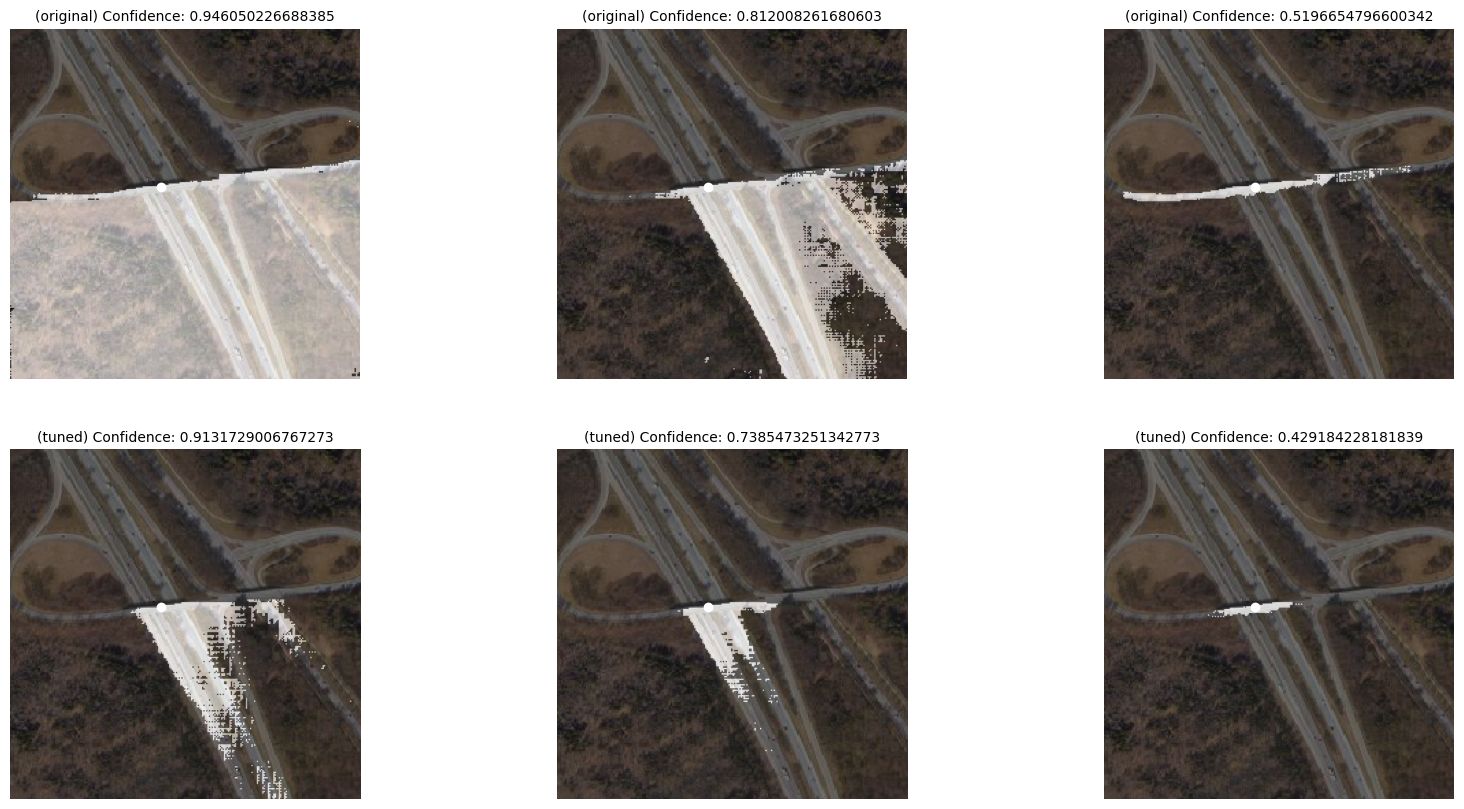

In [141]:
%matplotlib inline
_, axs = plt.subplots(2, max(len(confidences_orig), len(confidences_tuned)), figsize=(20, 10))

for ax_id in range(len(confidences_orig)):
  axs[0, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[0, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[0, ax_id].set_title(f'(original) Confidence: {confidences_orig[ax_id]}', fontsize=10)
  axs[0, ax_id].axis('off')

for ax_id in range(len(confidences_tuned)):
  axs[1, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[1, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[1, ax_id].set_title(f'(tuned) Confidence: {confidences_tuned[ax_id]}', fontsize=10)
  axs[1, ax_id].axis('off')

MSE (thresholded): tensor(0.0043, device='cuda:0')
MSE (natural): tensor(60.0276, device='cuda:0')
CE: tensor(0.0241, device='cuda:0')


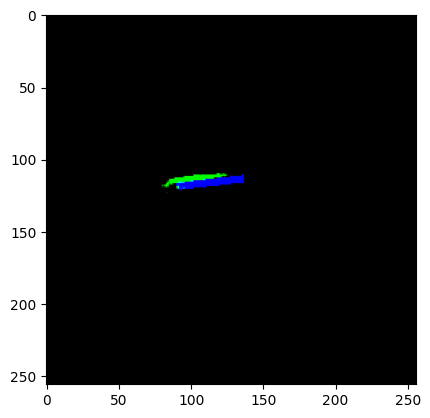

In [175]:
masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
    return_logits=True
)

masks_orig = masks_orig[0, ...]
masks_tuned = masks_tuned[0, ...]
zeros = np.zeros_like(masks_orig)
plt.imshow(np.stack([zeros, masks_orig,zeros], axis=-1) + np.stack([zeros, zeros, test_datapoint['mask']], axis=-1))

ce = torch.nn.CrossEntropyLoss()
mse = torch.nn.MSELoss()

mask_gt_tensor = torch.as_tensor(test_datapoint['mask'])[None, :, :].to(device)
mask_orig_tensor = torch.as_tensor(masks_orig)[None, :, :].to(device)
print('MSE (thresholded):', mse(mask_gt_tensor, normalize(threshold(mask_orig_tensor, 0.5, 0))))
print('MSE (natural):', mse(mask_gt_tensor, mask_orig_tensor))
print('CE:', ce(torch.stack([1-mask_orig_tensor, mask_orig_tensor], axis=1), gt_binary_mask[0]))

MSE (thresholded): tensor(0.0022, device='cuda:0')
MSE (natural): tensor(48.6216, device='cuda:0')
CE: tensor(0.0189, device='cuda:0')


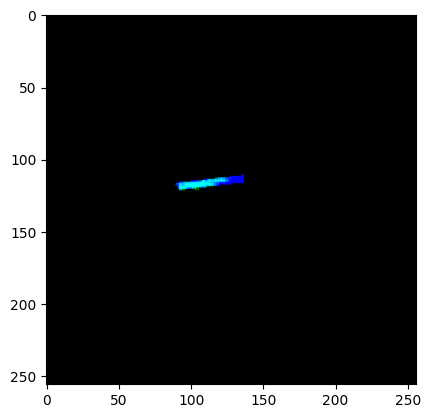

In [174]:

plt.imshow(np.stack([zeros,masks_tuned,zeros], axis=-1) + np.stack([zeros,zeros, test_datapoint['mask']], axis=-1))
mask_tuned_tensor = torch.as_tensor(masks_tuned)[None, :, :].to(device)
print('MSE (thresholded):', mse(mask_gt_tensor, normalize(threshold(mask_tuned_tensor, 0.5, 0))))
print('MSE (natural):', mse(mask_gt_tensor, mask_tuned_tensor))
print('CE:', ce(torch.stack([1-mask_tuned_tensor, mask_tuned_tensor], axis=1), gt_binary_mask[0]))